## Content based recommendation system 

Content based recommendation systems suggest similar items based on a particular item. This system uses item metadata, such as learning objectives, Language, Level, Subject, Instructor, etc. for courses, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it. Example of content based recommendation in Amazon:
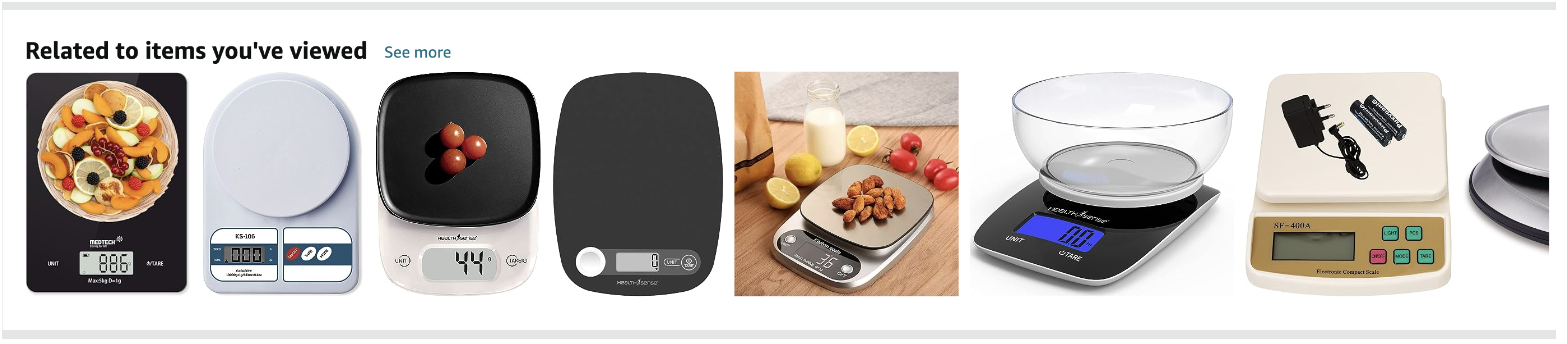

In this recommender system the content of the course is used to find its similarity with other courses. Then the courses that are most likely to be similar are recommended.

## Importing libraries

The first step of building the recommender system will be to import necessary libraries.

In [2]:
!pip install joblib

In [3]:
import pandas as pd
import re
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Loading data

The next step will be to load the data, the data exists in 3 csv files: one contains data about courses, one has subjects names, and one has data about the instructors. We'll use `pandas` library to load the csv files as `pandas` DataFrames. 

In [15]:
courses = pd.read_csv('../data/courses.csv')
subjects = pd.read_csv('../data/subjects.csv')
instructors = pd.read_csv('../data/instructors.csv')

Next, we will join the `courses` DataFrame with the `subjects` and the resulting DataFrame will be joined with the `instructors` DataFrame. The result will be one DataFrame that contains data about courses, subjects, and instructors 

In [16]:
courses = pd.merge(courses, subjects, left_on='SubjectId', right_on='Id', how='inner').rename(columns = {'Id_x': 'Id' , 'Name':'Subject'}).drop('Id_y',axis = 1)

In [17]:
courses = pd.merge(courses, instructors, left_on='InstructorId', right_on='Id', how='inner').rename(columns = {'Id_x': 'Id' , 'Name': 'Instructor_Name' , 'Expertise':'Instructor_Expertise'}).drop('Id_y',axis = 1)
courses.head()

Id  InstructorId  SubjectId                                    Title   
0   1             7          1  Introduction to Artificial Intelligence  \
1   1             7          1                 Deep Learning Essentials   
2   1             7          1                    AI Ethics and Society   
3   1             7          1             Computer Vision Fundamentals   
4   1             7          6  Web Performance Optimization Techniques   

  Language                     ThumbnailUrl  Price  Rating  Duration   
0  English     https://picsum.photos/48/959    668     4.6        15  \
1  English  https://placekitten.com/177/298    269     1.1        25   
2  English  https://placekitten.com/265/423    813     4.4        85   
3  English    https://picsum.photos/377/486    903     4.5        63   
4  English  https://placekitten.com/308/112    840     1.5        97   

   TotalEnrolled  ...  DeductionType   
0            138  ...     Percentage  \
1            812  ...     Percentage   
2            234  ...          Fixed   
3            511  ...     Percentage   
4            424  ...          Fixed   

                                  LearningObjectives   
0  - Understand the fundamental concepts and prin...  \
1  1. Understand the fundamentals of deep learnin...   
2  - Understand the ethical implications of artif...   
3  - Understand the basic concepts, theories, and...   
4  By the end of the course, students will be abl...   

                     LecturesLinks   
0               https://brown.com/  \
1  https://www.edwards-waters.com/   
2          https://www.harvey.com/   
3    http://www.davis-miller.info/   
4            https://friedman.com/   

                                 EnrolledStudentsIds   
0  [5891, 7609, 41778, 23259, 18502, 31478, 71726...  \
1  [3812, 83316, 64711, 7315, 32678, 51308, 94916...   
2  [32081, 41008, 71662, 76010, 57208, 37679, 109...   
3  [97559, 56772, 48764, 29402, 68624, 57608, 677...   
4                         [26199, 1412, 74145, 5904]   

                        PictureUrl   
0    https://dummyimage.com/602x62  \
1  https://placekitten.com/949/141   
2    https://picsum.photos/493/882   
3   https://placekitten.com/29/298   
4  https://placekitten.com/409/831   

                                             Reviews             Subject   
0  [{'Rating': 4.8, 'Comment': 'Project month mor...                "AI"  \
1  [{'Rating': 1.2, 'Comment': 'Remember bad most...                "AI"   
2  [{'Rating': 4.7, 'Comment': 'Gun red old marke...                "AI"   
3  [{'Rating': 1.9, 'Comment': 'Bill option go ch...                "AI"   
4  [{'Rating': 1.6, 'Comment': 'Alone begin detai...   "Web Development"   

  Instructor_Name language       Instructor_Expertise  
0       Kevin Lee  English  ['AI', 'Web Development']  
1       Kevin Lee  English  ['AI', 'Web Development']  
2       Kevin Lee  English  ['AI', 'Web Development']  
3       Kevin Lee  English  ['AI', 'Web Development']  
4       Kevin Lee  English  ['AI', 'Web Development']  

[5 rows x 24 columns]

Notice the `LearningObjectives` column, the data inside this column isn't in a consistent format. Some of them are numbered, others are dashed, we want to standardize the `LearningObjectives` column to be in the form of a paragraph, we also want to remove the new lines at the end of each learning objective. 

In [27]:
def clean_learning_objectives(learning_objectives):
    s = learning_objectives.replace('By the end of this course, students will be able to:' , '')
    # remove new lines and replace them with dots, then remove dashes at the beginning of each objective
    s = s.replace('\n' , '.').replace('- ' , ' ')
    # remove numbers at the beginning of each objective 
    s = re.sub('[0-9].' , '' , s)
    # remove double dots and remove beginning and trailing spaces
    s = re.sub('\.\.' , '.' , s).lstrip(' .')
    
    return s

courses['LearningObjectives'] = courses['LearningObjectives'].apply(clean_learning_objectives)

In [28]:
courses['LearningObjectives'] = courses['LearningObjectives'].apply(clean_learning_objectives)

## Step 1: Choosing features 

The first step in building the content based recommender system will be to choose which features we will use to decide which courses are most similar, we will choose the following features: course title, learning objectives, language, level, subject, instructor name, instructor expertise.

In [30]:
df = courses[['Title' , 'LearningObjectives', 'Language' , 'Level', 'Subject', 'Instructor_Name', 'Instructor_Expertise']]
df.head()

Title   
0  Introduction to Artificial Intelligence  \
1                 Deep Learning Essentials   
2                    AI Ethics and Society   
3             Computer Vision Fundamentals   
4  Web Performance Optimization Techniques   

                                  LearningObjectives Language         Level   
0  Understand the fundamental concepts and princi...  English      Advanced  \
1  Understand the fundamentals of deep learning, ...  English      Advanced   
2  Understand the ethical implications of artific...  English      Beginner   
3  Understand the basic concepts, theories, and a...  English      Advanced   
4  By the end of the course, students will be abl...  English  Intermediate   

              Subject Instructor_Name       Instructor_Expertise  
0                "AI"       Kevin Lee  ['AI', 'Web Development']  
1                "AI"       Kevin Lee  ['AI', 'Web Development']  
2                "AI"       Kevin Lee  ['AI', 'Web Development']  
3                "AI"       Kevin Lee  ['AI', 'Web Development']  
4   "Web Development"       Kevin Lee  ['AI', 'Web Development']

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 71 non-null     object
 1   LearningObjectives    71 non-null     object
 2   Language              71 non-null     object
 3   Level                 71 non-null     object
 4   Subject               71 non-null     object
 5   Instructor_Name       71 non-null     object
 6   Instructor_Expertise  71 non-null     object
dtypes: object(7)
memory usage: 4.0+ KB


Notice that the `Instructor_Expertise` column's data type is `object` but we want it to be a Python `List`, we will use the `literal_eval` function to do that. 

In [34]:
df['Instructor_Expertise'] = df['Instructor_Expertise'].apply(literal_eval)
df['Instructor_Expertise']

C:\Users\hp\AppData\Local\Temp\ipykernel_17144\2180319828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Instructor_Expertise'] = df['Instructor_Expertise'].apply(literal_eval)


0                [AI, Web Development]
1                [AI, Web Development]
2                [AI, Web Development]
3                [AI, Web Development]
4                [AI, Web Development]
                    ...               
66    [Web Development, Data Analysis]
67    [Web Development, Data Analysis]
68    [Web Development, Data Analysis]
69    [Web Development, Data Analysis]
70    [Web Development, Data Analysis]
Name: Instructor_Expertise, Length: 71, dtype: object

next, we want to convert all the text in each column to lowercase and remove all spaces, this is done for several reasons, such as:

- **Consistency in Data Representation:** By converting all text to lowercase and removing spaces, you ensure that similar strings are represented in a consistent manner. For instance, "Data Science" and "data science" will both be converted to "datascience". This consistency is crucial for accurately comparing and matching text data.

<br>

- **Accurate Text Matching:** Content-based recommender systems rely on measuring the similarity between text features of different items. Inconsistent representations (e.g., differing only in case or extra spaces) can lead to incorrect similarity calculations. By cleaning the data, you eliminate such discrepancies, leading to more accurate recommendations.

In [35]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        return str.lower(x.replace(" ", ""))

# Apply clean_data function to your features.
features = ['Subject', 'LearningObjectives', 'Level', 'Language', 'Instructor_Name']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

C:\Users\hp\AppData\Local\Temp\ipykernel_17144\3940365031.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].apply(clean_data)
C:\Users\hp\AppData\Local\Temp\ipykernel_17144\3940365031.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].apply(clean_data)
C:\Users\hp\AppData\Local\Temp\ipykernel_17144\3940365031.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer.

In [36]:
def create_soup(x):
    return ''.join(x['Subject']) + ' ' + ''.join(x['LearningObjectives']) + ''.join(x['Level']) + ' ' + x['Language'] + ' ' + ''.join(x['Instructor_Name'])
df['soup'] = df.apply(create_soup, axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_17144\689345907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soup'] = df.apply(create_soup, axis=1)


In [37]:
df['soup'] = df.apply(create_soup, axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_17144\3147030762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soup'] = df.apply(create_soup, axis=1)


In [38]:
df['soup']

0     "ai" understandthefundamentalconceptsandprinci...
1     "ai" understandthefundamentalsofdeeplearning,i...
2     "ai" understandtheethicalimplicationsofartific...
3     "ai" understandthebasicconcepts,theories,andal...
4     "webdevelopment" bytheendofthecourse,studentsw...
                            ...                        
66    "webdevelopment" identifycommonwebsecurityvuln...
67    "webdevelopment" studentswillbeableto:.underst...
68    "webdevelopment" understandtheconceptofwebsock...
69    "dataanalysis" understandfundamentalstatistica...
70    "dataanalysis" understandtheconcepts,technolog...
Name: soup, Length: 71, dtype: object

## Step 2: Vectorizing input features

After creating the "metadata soup", we want to convert it to numbers since computers can't understand text, we will use the `TfidfVectorizer` from `sklearn` to convert the "metadata soup" to a vector of numbers. <br>
<br>
To learn how does `TfidfVectorizer` work: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a.

In [39]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['soup'])

## Step3: Building the similarity matrix

After converting the "metadata soup" to a vector of numbers, we want to know which vectors(courses) are most similar, this is achieved using `cosine_similarity`. 
<br>
<br>
To learn how does `cosine_similarity` work: https://www.machinelearningplus.com/nlp/cosine-similarity/

In [40]:
cosine_sim_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Step 4: Using the similarity matrix to recommend courses

We are going to define a function that takes in a course title as an input and outputs a list of the 10 most similar courses. Firstly, for this, we need a reverse mapping of course titles and DataFrame indices. In other words, we need a mechanism to identify the index of a course in our metadata DataFrame, given its title.

In [41]:
# Reset index of our main DataFrame and construct reverse mapping as before
df = df.reset_index()
indices = pd.Series(df.index, index=df['Title'])

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the course given its title.
* Get the list of cosine similarity scores for that particular course with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the course most similar to a particular course is the course itself).
* Return the titles corresponding to the indices of the top elements.

In [42]:
# Function that takes in course title as input and outputs most similar courses
def get_recommendations(title, cosine_sim):
    # Get the index of the course that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all courses with that course
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the courses based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar courses
    sim_scores = sim_scores[1:11]

    # Get the course indices
    course_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar courses
    return df['Title'].iloc[course_indices]

In [43]:
df['Title'][49]

'Progressive Web Apps Development'

In [44]:
get_recommendations('Progressive Web Apps Development' , cosine_sim_tfidf)

50    Serverless Architecture with AWS Lambda
51                Web Accessibility Standards
48          Database Integration with MongoDB
45        JavaScript for Frontend Development
52                 Web Development with Flask
58           Responsive Web Design Principles
43             Go Programming Language Basics
44              Ruby Programming Fundamentals
46           Backend Development with Node.js
47      Building RESTful APIs with Express.js
Name: Title, dtype: object

We have finished building the content-based recommender system, as a final step we will save preprocessed data and computed matrices to be able to reuse them without having to recompute them each time.

In [45]:
import pickle

with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump((tfidf_matrix, cosine_sim_tfidf, df, indices), f)


In [46]:
!ls

preprocessed_data.pkl
Untitled.ipynb


In [24]:
with open('preprocessed_data.pkl', 'rb') as f:
    tfidf_matrix, cosine_sim_tfidf, df, indices = pickle.load(f)

In [25]:
tfidf_matrix

<71x632 sparse matrix of type '<class 'numpy.float64'>'
	with 923 stored elements in Compressed Sparse Row format>